# Introduction

1. I changed the keras code so that I could use it to update the actor model with a custom gradient
2. I am adding parameter noise, as suggested by OpenAI

When doing a hyperparameter search, I solved the problem at the parameter values below (see the figures in the stats/ folder). But, I'm having a hard time reproducing. This is to be expected, since there is randomness in tensorflow. According to link below, you should re-run the same net a bunch of times, and find the average; makes sense, although costly from a training perspective. Another option is to seed tensorflow. 

I'm going to do both, run an ensemble at the same parameter values, but with specified seeds. That way, at testing time, I can use the specified seed.

https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

Notes: getting the action exploration right was the hard part. I believe (must check more rigorously) that adding the parameter noise was the key

Note, I have not included an entropy term is the policy loss. Maybe I should

/home/kokeeffe/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
(episode, score, steps, T (mins)) = (10, 26.153087326679852, 864, 1.3380062500635783)
(episode, score, steps, T (mins)) = (20, -99.89958232787522, 999, 1.6039602319399515)
(episode, score, steps, T (mins)) = (30, -98.2746383635147, 999, 1.6069171150525412)
(episode, score, steps, T (mins)) = (40, -99.89999763965568, 999, 1.603422431151072)
(episode, score, steps, T (mins)) = (50, -97.05773244595582, 999, 1.6049902002016703)
(episode, score, steps, T (mins)) = (60, -93.86789149883644, 999, 1.6051076809565226)
(episode, score, steps, T (mins)) = (70, -99.8999999999986, 999, 1.607503314812978)
(episode, score, steps, T (mins)) = (80, -97.80265947238367, 999, 1.606589436531067)
(episode, score, steps, T (mins)) = (90, -99.8999999999986, 999, 1.6073578516642253)
(episode, score, steps, T (mins)) = 

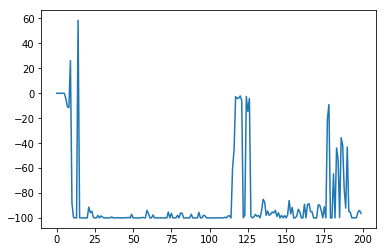

In [1]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
from agent import Agent
%matplotlib inline

#Environment
seed = 6
env = gym.make('MountainCarContinuous-v0')
env.seed(seed)  # for comparison
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

#Agent
gamma, lr, tau = 0.99, 0.0001, 0.001
agent = Agent(num_states, num_actions, lr, gamma, seed_num = seed)
agent.memory_size = 10**4
agent.batchsize = 256
learning_start = 25*agent.batchsize
agent.tau = tau


#Train
EPISODES = 200
MAX_STEPS = 1000
scores = []
for e in range(1,EPISODES+1):
    state = env.reset()
    reward_sum = 0
    done = False
    steps = 0
    t1 = time.time()
    
    while not done:
        #env.render()
        state = np.reshape(state, [1, num_states])  #reshape for keras
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward_sum += reward
        agent.remember(state[0], action, reward, next_state, done)
        state = next_state
        
        if len(agent.memory) > learning_start:
            agent.train_models()
        
        steps += 1
        if done or steps > MAX_STEPS:
            break
    
    #Learn & print results
    scores.append(reward_sum)
    t2 = time.time()
    if e % 10 == 0:
        print '(episode, score, steps, T (mins)) = ' + str((e,reward_sum, steps, (t2-t1)/60.0))

agent.save_target_weights()
plt.plot(scores)
#np.savetxt('stats/scores_inverted_pendulum.txt',scores)

### Watch a smart agent

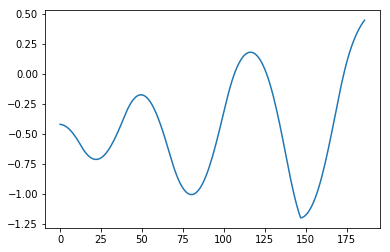

In [22]:
state = env.reset()
reward_sum = 0
done = False
r_list = []
pos = []
while not done:
    #env.render()
    state = np.reshape(state, [1, num_states])  #reshape for keras
    pos.append(state[0][0])
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    reward_sum += reward
    r_list.append(reward)
    agent.remember(state[0], action, reward, next_state, done)
    state = next_state
    if done:
        break
#env.close()
plt.plot(pos)